# Training RNN on Rowing Skeletons
The purpose of this notebook is to train an RNN on the rowing skeleton data that Emelie generated. After training the RNN, we will classify the ability of the rower using the RNN activations.

## Imports

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## Create dataset

In [ ]:
drive_locations = [
    '/content/drive/MyDrive/Keith_Emelie_final/PR1_vid1/PR1_coordinates_v_a_angle.csv',
    '/content/drive/MyDrive/Keith_Emelie_final/PR1_vid2/PR2_1_2_coordinates_v_a_angle.csv',
    '/content/drive/MyDrive/Keith_Emelie_final/PR2_vid1/PR2_coordinates_v_a_angle.csv',
    '/content/drive/MyDrive/Keith_Emelie_final/PR2_vid2/PR2_2_coordinates_v_a_angle.csv',
    '/content/drive/MyDrive/Keith_Emelie_final/PR3_vid1/PR2_3_1_coordinates_v_a_angle.csv',
    '/content/drive/MyDrive/Keith_Emelie_final/PR3_vid21/PR2_3_2_coordinates_v_a_angle.csv',
]
pr_labels = [
    'PR1',
    'PR1',
    'PR2',
    'PR2',
    'PR3',
    'PR3',
]

In [ ]:
def drop_columns(df):
    # Find columns that do not have exactly 3 underscores
    cols_to_drop = [col for col in df.columns if col.count('_') != 2 or 'coco' in col]

    # Drop these columns
    df.drop(columns=cols_to_drop, inplace=True)

    return df

def all_lists_identical(list_of_lists):
    # Check if list_of_lists is empty or contains only one list
    if not list_of_lists or len(list_of_lists) == 1:
        return True

    # Take the first list as the reference
    first_list = list_of_lists[0]

    # Compare each subsequent list with the first list
    for lst in list_of_lists[1:]:
        if lst != first_list:
            return False

    return True

def equalize_df_lengths(df_list):
    # Determine the length of the shortest DataFrame
    min_length = min(len(df) for df in df_list)

    # Modify each DataFrame to match the shortest length
    for i in range(len(df_list)):
        # Truncate if longer
        if len(df_list[i]) > min_length:
            df_list[i] = df_list[i].iloc[:min_length]
        # Extend if shorter
        elif len(df_list[i]) < min_length:
            # Create a DataFrame with NaNs to append
            additional_rows = min_length - len(df_list[i])
            columns = df_list[i].columns
            df_to_append = pd.DataFrame([[pd.NA] * len(columns)] * additional_rows, columns=columns)
            df_list[i] = pd.concat([df_list[i], df_to_append], ignore_index=True)

    return df_list

In [ ]:
def drop_columns(df):
    # Find columns that don't start with "V"
    cols_to_drop = [col for col in df.columns if not col.startswith('Angle')]

    # Drop these columns
    df.drop(columns=cols_to_drop, inplace=True)

    return df

In [ ]:
csv_df = [drop_columns(pd.read_csv(i))for i in drive_locations]

In [ ]:
#csv_df = [pd.read_csv(i) for i in drive_locations]

In [ ]:
csv_df_column_names = [list(i.columns) for i in csv_df]
all_lists_identical(csv_df_column_names)

True

In [ ]:
csv_df = equalize_df_lengths(csv_df)

In [ ]:
csv_df_lens = [len(i) for i in csv_df]
csv_df_lens

[328, 328, 328, 328, 328, 328]

In [ ]:
np_key_points = np.stack([i.to_numpy() for i in csv_df], axis=0)
np_key_points.shape


(6, 328, 72)

In [ ]:
reshaped_data = np.reshape(np_key_points, (6 * 328, np_key_points.shape[-1]))
reshaped_data.shape


(1968, 72)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your data is stored in a variable called 'data'
# Create labels
labels = np.repeat(np.arange(3), 656)

# Add labels as a new column to your data
data_with_labels = np.column_stack((reshaped_data, labels))

# Shuffle the data
np.random.shuffle(data_with_labels)

# Separate features and labels
X = data_with_labels[:, :-1]
y = data_with_labels[:, -1]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, y_test for your classifier


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define a simple neural network model
#class SimpleClassifier(nn.Module):
    #def __init__(self, input_size, output_size):
        #super(SimpleClassifier, self).__init__()
        #self.fc = nn.Linear(input_size, output_size)

    #def forward(self, x):
        #x = self.fc(x)
        #return x

class DenseClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DenseClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model

input_size = X_train.shape[1]
hidden_size = 64  # You can adjust the hidden layer size based on your requirements
output_size = len(np.unique(y_train))

print(input_size)
#model = DenseClassifier(input_size, output_size)
model = DenseClassifier(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
epochs = 10

for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


72
Accuracy on the test set: 94.92%


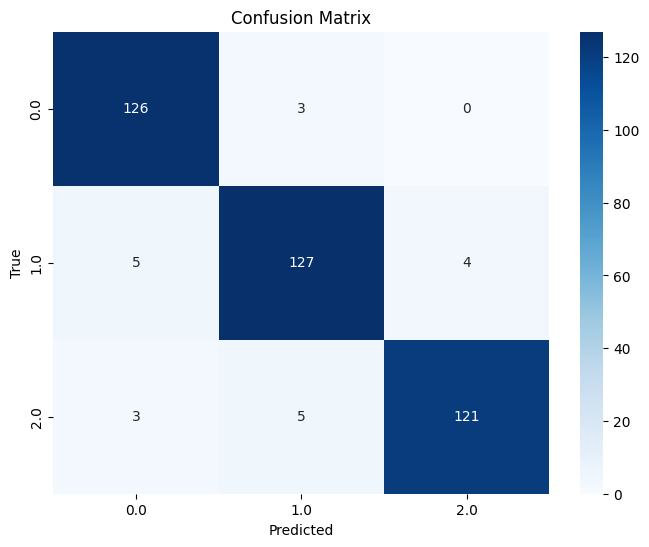

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions to numpy array
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    y_pred = predicted.numpy()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import plotly.graph_objects as go

def plot_percentage_bar(percentage_data, labels):
    # Create a Plotly bar graph
    fig = go.Figure(data=[go.Bar(x=labels, y=percentage_data)])

    # Add a horizontal line at y = 30
    fig.add_shape(type='line',
                  x0=0,
                  x1=labels[-1],
                  y0=33.3,
                  y1=33.3,
                  line=dict(color='red', width=2))

    # Update layout for better visibility
    fig.update_layout(title='Percentage Distribution',
                      xaxis=dict(title='Labels'),
                      yaxis=dict(title='Percentage % Correct Classified'))

    # Show the plot
    fig.show()

# Example usage
percentage_data = [93.15, 61.42, 65.23, 34.26, 36.04]  # Replace this with your actual percentage data
labels = ['Keypoints', 'Velocity', 'Acceleration', 'Angles', 'All' ]  # Replace this with your actual labels

plot_percentage_bar(percentage_data, labels)


In [ ]:
# Assuming your array is named 'data'
reshaped_data = np.reshape(np_key_points, (6 * 328, 72))
total_frames = 6 * 328
# Create labels
label_mapping = {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2}  # Map groups to labels
labels = np.array([label_mapping[i // 328] for i in range(total_frames)])

from sklearn.model_selection import train_test_split

# Assuming 'reshaped_data' and 'labels' are your reshaped data and labels
X_train, X_val, y_train, y_val = train_test_split(reshaped_data, labels, test_size=0.2, random_state=42)


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_shape=(72,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))





Epoch 1/50
50/50 [==============================] - 2s 10ms/step - loss: 0.9346 - accuracy: 0.6722 - val_loss: 0.7560 - val_accuracy: 0.8020
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.6013 - accuracy: 0.8107 - val_loss: 0.4767 - val_accuracy: 0.8706
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.3445 - accuracy: 0.9212 - val_loss: 0.2926 - val_accuracy: 0.9162
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2006 - accuracy: 0.9543 - val_loss: 0.1939 - val_accuracy: 0.9492
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1324 - accuracy: 0.9663 - val_loss: 0.1196 - val_accuracy: 0.9695
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1014 - accuracy: 0.9740 - val_loss: 0.0891 - val_accuracy: 0.9797
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0796 - accuracy: 0.9809 - val_loss: 0.0982 - val_accuracy: 0.9670
Epoch 8/50
50/50 [=

In [ ]:
n, T, f = np_key_points.shape

In [ ]:
# Generate a random vector of length 20 for each dataset
random_vectors = np.random.rand(n, 20)

# Replicate each vector T times within its dataset
embedding_vectors = np.repeat(random_vectors[:, np.newaxis, :], T, axis=1)

# new_array is now of shape (n, T, 20)
# Each dataset has its own random vector repeated T times
embedding_vectors.shape

(6, 328, 20)

## Experiment with RNN

In [ ]:
class TimeSeriesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

    def rates(self, x):
        out, _ = self.rnn(x)
        return out

In [ ]:
def get_incremental_data(epoch, max_data_size, step_size, embedding_vectors_tensor, np_key_points_tensor):
    # Increase data size with each step until the maximum size is reached
    data_size = min(max(int(step_size * epoch), 1), max_data_size)
    return embedding_vectors_tensor[:data_size], np_key_points_tensor[:data_size]

In [ ]:
# Initialize the model, loss function, and optimizer
input_size = 20
hidden_size = 200  # Example value, needs tuning
output_size = f   # Number of features in np_key_points

model = TimeSeriesRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

# Convert data to PyTorch tensors
embedding_vectors_tensor = torch.tensor(embedding_vectors, dtype=torch.float32)
np_key_points_tensor = torch.tensor(np_key_points, dtype=torch.float32)

# Curriculum learning
num_epochs = 7500
max_data_size = len(embedding_vectors_tensor)
step_size = 0.002
min_loss = float('inf')
min_epoch = None

In [ ]:
for epoch in tqdm(range(num_epochs)):
    break # Training takes 26 minutes. Be careful commenting this break point out.
    model.train()
    optimizer.zero_grad()

    # Get the subset of data for the current epoch
    current_emb_vectors, current_key_points = get_incremental_data(epoch, max_data_size, step_size, embedding_vectors_tensor, np_key_points_tensor)

    # Forward pass with the current subset of data
    output = model(current_emb_vectors)
    loss = criterion(output, current_key_points)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Check if the current loss is the lowest
    if loss.item() < min_loss and epoch > int(max_data_size/step_size + 10):
        min_loss = loss.item()
        min_epoch = epoch
        torch.save(model.state_dict(), '/content/drive/MyDrive/Keith_Emelie_final/RNN/best_model.pth')

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}')

  7%|▋         | 501/7500 [01:28<18:43,  6.23it/s]

Epoch [500/7500], Loss: 0.00757


 13%|█▎        | 1000/7500 [02:50<20:42,  5.23it/s]

Epoch [1000/7500], Loss: 0.00759


 20%|██        | 1501/7500 [04:26<16:51,  5.93it/s]

Epoch [1500/7500], Loss: 0.00661


 27%|██▋       | 2001/7500 [06:04<16:39,  5.50it/s]

Epoch [2000/7500], Loss: 0.00802


 33%|███▎      | 2501/7500 [07:52<14:54,  5.59it/s]

Epoch [2500/7500], Loss: 0.00959


 40%|████      | 3001/7500 [09:39<13:49,  5.42it/s]

Epoch [3000/7500], Loss: 0.00155


 47%|████▋     | 3501/7500 [11:31<13:03,  5.11it/s]

Epoch [3500/7500], Loss: 0.00167


 53%|█████▎    | 4001/7500 [13:21<11:13,  5.20it/s]

Epoch [4000/7500], Loss: 0.00143


 60%|██████    | 4500/7500 [15:12<11:29,  4.35it/s]

Epoch [4500/7500], Loss: 0.00134


 67%|██████▋   | 5000/7500 [17:06<11:24,  3.65it/s]

Epoch [5000/7500], Loss: 0.00115


 73%|███████▎  | 5500/7500 [18:57<09:14,  3.60it/s]

Epoch [5500/7500], Loss: 0.00106


 80%|████████  | 6000/7500 [20:48<06:05,  4.11it/s]

Epoch [6000/7500], Loss: 0.00107


 87%|████████▋ | 6501/7500 [22:38<03:07,  5.32it/s]

Epoch [6500/7500], Loss: 0.00085


 93%|█████████▎| 7001/7500 [24:29<01:35,  5.24it/s]

Epoch [7000/7500], Loss: 0.00078


100%|██████████| 7500/7500 [26:19<00:00,  4.75it/s]

Epoch [7500/7500], Loss: 0.00075


In [ ]:
print(f'Minimum Loss: {min_loss:.5f}')
print(f'Minimum Loss Epoch: {min_epoch}')

Minimum Loss: 0.00072
Minimum Loss Epoch: 7486


## RNN analysis

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Keith_Emelie_final/RNN/best_model.pth'))
model.eval()

TimeSeriesRNN(
  (rnn): GRU(20, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=72, bias=True)
)

In [ ]:
output = model(embedding_vectors_tensor)
output = output.detach().numpy()

(328, 72)

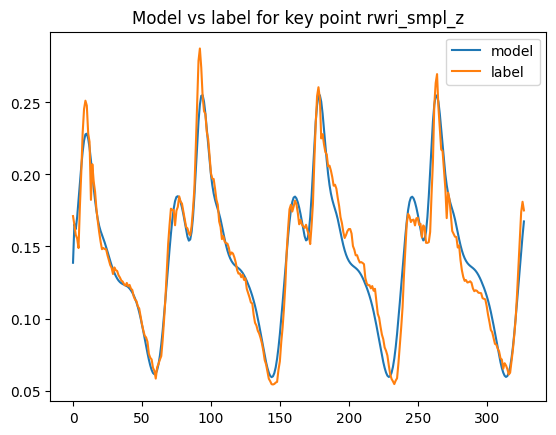

In [ ]:
key_point_name = csv_df_column_names[0][65]

plt.plot(output[0, :, 65], label='model')
plt.plot(np_key_points_tensor[0, :, 65], label='label')
plt.title(f"Model vs label for key point {key_point_name}")
plt.legend()
plt.show()

In [ ]:
model_rates = model.rates(embedding_vectors_tensor)
model_rates = model_rates.detach().numpy()
model_rates.shape

(6, 328, 200)

In [ ]:
# Assuming 'rates' is your (6, 328, 200) array
# Reshape the data for PCA
n_datasets, n_timepoints, n_features = model_rates.shape
reshaped_rates = model_rates.reshape(n_datasets * n_timepoints, n_features)

# Apply PCA
pca = PCA(n_components=3)
rates_pca = pca.fit_transform(reshaped_rates)

# Reshape the transformed data back for plotting
rates_pca_reshaped = rates_pca.reshape(n_datasets, n_timepoints, 3)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each dataset in a different color
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i in range(n_datasets):
    ax.scatter(rates_pca_reshaped[i, :, 0],  # PCA component 1
               rates_pca_reshaped[i, :, 1],  # PCA component 2
               rates_pca_reshaped[i, :, 2],  # PCA component 3
               c=colors[i], label=f'Dataset {i}')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.title('3D PCA of Neural Rates')
plt.show()
